# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Will-a-tropical-storm-make-landfall?" data-toc-modified-id="Will-a-tropical-storm-make-landfall?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Will a tropical storm make landfall?</a></div><div class="lev2 toc-item"><a href="#Generate-the-dataset" data-toc-modified-id="Generate-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate the dataset</a></div><div class="lev3 toc-item"><a href="#Dataset-description" data-toc-modified-id="Dataset-description-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Dataset description</a></div><div class="lev3 toc-item"><a href="#Open-the-source-dataset" data-toc-modified-id="Open-the-source-dataset-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Open the source dataset</a></div><div class="lev3 toc-item"><a href="#Extract,-transform-and--load-features-(ETL)" data-toc-modified-id="Extract,-transform-and--load-features-(ETL)-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Extract, transform and  load features (ETL)</a></div><div class="lev3 toc-item"><a href="#class-label-distribution-of-filtered-source-dataset" data-toc-modified-id="class-label-distribution-of-filtered-source-dataset-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>class label distribution of filtered source dataset</a></div><div class="lev3 toc-item"><a href="#Generate-random-sampling-of-each-prediction-(class)-value-and-generate-ARFF-file" data-toc-modified-id="Generate-random-sampling-of-each-prediction-(class)-value-and-generate-ARFF-file-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Generate random sampling of each prediction (class) value and generate ARFF file</a></div><div class="lev3 toc-item"><a href="#breakdown-of-dataset-records-used-for-training-and-test-sets" data-toc-modified-id="breakdown-of-dataset-records-used-for-training-and-test-sets-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>breakdown of dataset records used for training and test sets</a></div><div class="lev3 toc-item"><a href="#training-set-class-label-distribution-of-randomly-sampled-datasets-of-each-class-value" data-toc-modified-id="training-set-class-label-distribution-of-randomly-sampled-datasets-of-each-class-value-1.1.7"><span class="toc-item-num">1.1.7&nbsp;&nbsp;</span>training set class label distribution of randomly sampled datasets of each class value</a></div><div class="lev3 toc-item"><a href="#Save-DataFrame-datasets-(all,-landfall/nolandfall-training-sets-and-test-set)-as-tables-in-HDF5" data-toc-modified-id="Save-DataFrame-datasets-(all,-landfall/nolandfall-training-sets-and-test-set)-as-tables-in-HDF5-1.1.8"><span class="toc-item-num">1.1.8&nbsp;&nbsp;</span>Save DataFrame datasets (all, landfall/nolandfall training sets and test set) as tables in HDF5</a></div><div class="lev3 toc-item"><a href="#Visualize-the-dataset-storms-tracks" data-toc-modified-id="Visualize-the-dataset-storms-tracks-1.1.9"><span class="toc-item-num">1.1.9&nbsp;&nbsp;</span>Visualize the dataset storms tracks</a></div><div class="lev2 toc-item"><a href="#Machine-learning-analysis" data-toc-modified-id="Machine-learning-analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Machine learning analysis</a></div><div class="lev3 toc-item"><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Decision Tree</a></div><div class="lev4 toc-item"><a href="#DecisionTreeClassifier-using-Gini-impurity" data-toc-modified-id="DecisionTreeClassifier-using-Gini-impurity-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>DecisionTreeClassifier using Gini impurity</a></div><div class="lev4 toc-item"><a href="#DecisionTreeClassifier-using-entropy-for-information-gain" data-toc-modified-id="DecisionTreeClassifier-using-entropy-for-information-gain-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>DecisionTreeClassifier using entropy for information gain</a></div><div class="lev4 toc-item"><a href="#Decision-Tree-Analysis" data-toc-modified-id="Decision-Tree-Analysis-1.2.1.3"><span class="toc-item-num">1.2.1.3&nbsp;&nbsp;</span>Decision Tree Analysis</a></div><div class="lev3 toc-item"><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Naive Bayes</a></div><div class="lev4 toc-item"><a href="#Gaussian-Naive-Bayes-classifier-where-the-likelihood-of-the-features-is-assumed-to-be-Gaussian" data-toc-modified-id="Gaussian-Naive-Bayes-classifier-where-the-likelihood-of-the-features-is-assumed-to-be-Gaussian-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>Gaussian Naive Bayes classifier where the likelihood of the features is assumed to be Gaussian</a></div><div class="lev4 toc-item"><a href="#Bernoulli-Naive-Bayes-classifier-for-data-that-is-distributed-according-to-multivariate-Bernoulli-distributions" data-toc-modified-id="Bernoulli-Naive-Bayes-classifier-for-data-that-is-distributed-according-to-multivariate-Bernoulli-distributions-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span>Bernoulli Naive Bayes classifier for data that is distributed according to multivariate Bernoulli distributions</a></div><div class="lev4 toc-item"><a href="#Naive-Bayes-Analysis" data-toc-modified-id="Naive-Bayes-Analysis-1.2.2.3"><span class="toc-item-num">1.2.2.3&nbsp;&nbsp;</span>Naive Bayes Analysis</a></div><div class="lev3 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev4 toc-item"><a href="#Logistic-Regression-Analysis" data-toc-modified-id="Logistic-Regression-Analysis-1.2.3.1"><span class="toc-item-num">1.2.3.1&nbsp;&nbsp;</span>Logistic Regression Analysis</a></div><div class="lev3 toc-item"><a href="#Nearest-Neighbor" data-toc-modified-id="Nearest-Neighbor-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Nearest Neighbor</a></div><div class="lev4 toc-item"><a href="#Nearest-Neighbor-Analysis" data-toc-modified-id="Nearest-Neighbor-Analysis-1.2.4.1"><span class="toc-item-num">1.2.4.1&nbsp;&nbsp;</span>Nearest Neighbor Analysis</a></div><div class="lev3 toc-item"><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Support Vector Machines</a></div><div class="lev4 toc-item"><a href="#SVM-Analysis" data-toc-modified-id="SVM-Analysis-1.2.5.1"><span class="toc-item-num">1.2.5.1&nbsp;&nbsp;</span>SVM Analysis</a></div><div class="lev3 toc-item"><a href="#Final-Analysis" data-toc-modified-id="Final-Analysis-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Final Analysis</a></div>

* **FA16-BL-INFO-I526-34917**
* **Applied Machine Learning**
* **Gerald Manipon, MS Data Science student - Indiana University**
* **gmanipon@iu.edu**
* **this jupyter notebook can be found here: https://github.com/pymonger/tropicalstorm-ml-analysis**

# Will a tropical storm make landfall?

As a native of the Hawaiian Islands, the recent tropical storms in 2016 (Madeline and Lester) that threatened the state has sparked a very interesting and personal question. Can we predict whether or not a tropical storm will make landfall and possibly affect the safety and lives of the inhabitants? Currently there are real-time storm tracking models that enable our emergency response agencies to be as responsive as possible and to give up-to-the-minute status on potential threats. However, what does historical data say and can we predict landfall using machine learning on the initial observation of a tropical storm?

## Generate the dataset

### Dataset description

The source dataset I will use comes from the IBTrACS (International Best Track Archive for Climate Stewardship) project: https://www.ncdc.noaa.gov/ibtracs/index.php. This project is endorsed by the WMO (World Meteorological Organization) as an "official archiving and distribution resource for tropical cyclone best track data". The IBTrACS project provides datasets that:

* Contains the most complete global set of historical tropical cyclones available
* Combines information from numerous tropical cyclone datasets
* Simplifies inter-agency comparisons by providing storm data from multiple sources in one place
* Provides data in popular formats to facilitate analysis
* Checks the quality of storm inventories, positions, pressures, and wind speeds, passing the information on to the user

I will be using the IBTrACS-WMO NetCDF file that contains all storms: https://www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data. Since NetCDF is a self-describing format, info about the variables contained in this dataset can be introspected. Additional info about the variables is located here: ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r08/wmo/netcdf/README.netcdf.

I will be performing some ETL (extraction, transformation and loading) tasks to prepare and filter (remove records with missing values) the source dataset to a derived dataset which I will use for this analysis. The source dataset essentially aggregates every recorded tropical storm from different source agencies and provides time-series information of pertinent variables describing the storm as it progressed through its track. *Since I'm only interested in being able to predict whether or not the storm will make landfall based on the storm's genesis and initial observation, my derived dataset will be composed of features that are essentially the values of the source dataset variables at observation **t<sub>0</sub>**.*

The class variable (prediction variable) will be derived from the source dataset's **landfall** variable:

* **landfall** { True, False }
```
    short landfall(storm, time) ;
        landfall:long_name = "Minimum distance to land until next report (0=landfall)" ;
        landfall:units = "km" ;
        landfall:_FillValue = -999s ;
```

I will aggregate this variable into a single value of **True** or **False**. **True** signifies that the storm eventually made landfall at some point in the storm's track and **False** otherwise.

The features I will include from the source dataset are:

* **genesis_basin** { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian }
  ```
    byte genesis_basin(storm) ;
        genesis_basin:long_name = "Basin of genesis" ;
        genesis_basin:units = " " ;
        genesis_basin:key = "0 = NA - North Atlantic\n",
    "1 = SA - South Atlantic\n",
    "2 = WP - West Pacific\n",
    "3 = EP - East Pacific\n",
    "4 = SP - South Pacific\n",
    "5 = NI - North Indian\n",
    "6 = SI - South Indian\n",
    "7 = AS - Arabian Sea\n",
    "8 = BB - Bay of Bengal\n",
    "9 = EA - Eastern Australia\n",
    "10 = WA - Western Australia\n",
    "11 = CP - Central Pacific\n",
    "12 = CS - Carribbean Sea\n",
    "13 = GM - Gulf of Mexico\n",
    "14 = MM - Missing" ;
        genesis_basin:Note = "Based on where the storm began" ;
  ```
  * the additional variable info at ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r08/wmo/netcdf/README.netcdf states that only values 0-6 are used for this variable thus I will be discretizing the values for this feature
* **sub_basin** of first observation { 0 = NA - North Atlantic, 1 = SA - South Atlantic, 2 = WP - West Pacific, 3 = EP - East Pacific, 4 = SP - South Pacific, 5 = NI - North Indian, 6 = SI - South Indian, 7 = AS - Arabian Sea, 8 = BB - Bay of Bengal, 9 = EA - Eastern Australia, 10 = WA - Western Australia, 11 = CP - Central Pacific, 12 = CS - Carribbean Sea, 13 = GM - Gulf of Mexico, 14 = MM - Missing }
  ```
    byte sub_basin(storm, time) ;
        sub_basin:long_name = "Sub-Basin" ;
        sub_basin:units = " " ;
        sub_basin:key = "0 = NA - North Atlantic\n",
    "1 = SA - South Atlantic\n",
    "2 = WP - West Pacific\n",
    "3 = EP - East Pacific\n",
    "4 = SP - South Pacific\n",
    "5 = NI - North Indian\n",
    "6 = SI - South Indian\n",
    "7 = AS - Arabian Sea\n",
    "8 = BB - Bay of Bengal\n",
    "9 = EA - Eastern Australia\n",
    "10 = WA - Western Australia\n",
    "11 = CP - Central Pacific\n",
    "12 = CS - Carribbean Sea\n",
    "13 = GM - Gulf of Mexico\n",
    "14 = MM - Missing" ;
        sub_basin:Note = "Based on present location" ;
        sub_basin:_FillValue = '\201' ;
  ```
  * this feature will remain numeric since there are 14 values
* **time** of first observation (MJD value) (REAL)
  ```
    double time_wmo(storm, time) ;
        time_wmo:long_name = "Modified Julian Day" ;
        time_wmo:units = "days since 1858-11-17 00:00:00" ;
        time_wmo:_FillValue = 9.969209999999999e+36 ;
  ```
* **lon** (longitude) of first observation (REAL)
  ```
    short lon_wmo(storm, time) ;
        lon_wmo:long_name = "Storm center longitude" ;
        lon_wmo:units = "degrees_east" ;
        lon_wmo:scale_factor = 0.0099999998f ;
        lon_wmo:_FillValue = -32767s ;
  ```
* **lat** (latitude) of first observation (REAL)
  ```
    short lat_wmo(storm, time) ;
        lat_wmo:long_name = "Storm center latitude" ;
        lat_wmo:units = "degrees_north" ;
        lat_wmo:scale_factor = 0.0099999998f ;
        lat_wmo:_FillValue = -32767s ;
  ```
* **dist2land** (distance to land) of first observation (REAL)
  ```
    short dist2land(storm, time) ;
        dist2land:long_name = "Distance to land" ;
        dist2land:units = "km" ;
        dist2land:_FillValue = -999s ;
  ```
* **msw** (maximum sustained wind) of first observation (REAL)
  ```
    short pres_wmo(storm, time) ;
        pres_wmo:long_name = "Minimum Central Pressure (MCP)" ;
        pres_wmo:units = "mb" ;
        pres_wmo:scale_factor = 0.1f ;
        pres_wmo:_FillValue = -32767s ;
  ```
* **mcp** (minimum central pressure) of first observation (REAL)
  ```
    short wind_wmo(storm, time) ;
        wind_wmo:long_name = "Maximum Sustained Wind (MSW)" ;
        wind_wmo:units = "kt" ;
        wind_wmo:scale_factor = 0.1f ;
        wind_wmo:_FillValue = -32767s ;
  ```
* **nature** (storm nature) { 0 = TS - Tropical, 1 = SS - Subtropical, 2 = ET - Extratropical, 3 = DS - Disturbance, 4 = MX - Mix of conflicting reports, 5 = NR - Not Reported, 6 = MM - Missing, 7 = - Missing }
  ```
        nature_wmo:long_name = "Storm nature" ;
        nature_wmo:key = "0 = TS - Tropical\n",
    "1 = SS - Subtropical\n",
    "2 = ET - Extratropical\n",
    "3 = DS - Disturbance\n",
    "4 = MX - Mix of conflicting reports\n",
    "5 = NR - Not Reported\n",
    "6 = MM - Missing\n",
    "7 =  - Missing" ;
        nature_wmo:Note = "Based on classification from original sources" ;
        nature_wmo:_FillValue = '\201' ;
  ```
  * this feature will be discretized
* **track_type** { 0 = main - cylclogenesis to cyclolysis, 1 = merge - cyclogenesis to merger, 2 = split - split to cyclolysis, 3 = other - split to merger }
  ```
    byte track_type(storm) ;
        track_type:long_name = "Track type" ;
        track_type:key = "0 = main - cyclogenesis to cyclolysis\n",
    "1 = merge - cyclogenesis to merger\n",
    "2 = split - split to cyclolysis\n",
    "3 = other - split to merger" ;
  ```
  * this feature will be discretized


### Open the source dataset

In [1]:
import os, sys, re, json, arff, time
from copy import deepcopy
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
from ipyleaflet import Map, GeoJSON
from astropy.time import Time
from IPython.display import display, HTML, Markdown


# get netcdf dataset
file = "Allstorms.ibtracs_wmo.v03r10.nc"
ds = NC.Dataset(file)

### Extract, transform and  load features (ETL)

In [2]:
# define dict for discrete features
disc_map = {
    "basin": {
         0: "NA", # North Atlantic
         1: "SA", # South Atlantic
         2: "WP", # West Pacific
         3: "EP", # East Pacific
         4: "SP", # South Pacific
         5: "NI", # North Indian
         6: "SI", # South Indian
         7: "AS", # Arabian Sea
         8: "BB", # Bay of Bengal
         9: "EA", # Eastern Australia
        10: "WA", # Western Australia
        11: "CP", # Central Pacific
        12: "CS", # Carribbean Sea
        13: "GM", # Gulf of Mexico
        14: "MM", # Missing
    },
    "nature": {
        0: "TS",  # Tropical
        1: "SS",  # Subtropical
        2: "ET",  # Extratropical
        3: "DS",  # Disturbance
        4: "MX",  # Mix of conflicting reports
        5: "NR",  # Not Reported
        6: "MM",  # Missing
        7: "MM2", # Also Missing
    },
    "track_type": {
        0: "main",  # cyclogenesis to cyclolysis
        1: "merge", # cyclogenesis to merger
        2: "split", # split to cyclolysis
        3: "other", # split to merger
    },
    "month": {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
       10: "Oct",
       11: "Nov",
       12: "Dec",
    }
}

# extract features from each hurricane and save into a list of dicts
data = []
landfall_count = 0

# compile regular expression for matching unnamed storms
unnamed_re = re.compile(r'(UNNAMED|NOT NAMED)')

for i in range(ds.dimensions['storm'].size):
    
    # get number of observations
    obs = ds.variables['numObs'][i]
    if obs <= 2: continue # skip if there are 2 or less observations
    
    # get storm id (storm names can be re-used so we need to track them uniquely)
    id = np.array_str(NC.chartostring(ds.variables['storm_sn'][i,:]))[2:-1]
    
    # extract filterable features first
    name = np.array_str(NC.chartostring(ds.variables['name'][i,:]))[2:-1]
    genesis_basin = ds.variables['genesis_basin'][i]
    sub_basin = ds.variables['sub_basin'][i,:obs-1]
    nature = ds.variables['nature_wmo'][i:,obs-1]
    
    # skip records that have missing values in features
    if genesis_basin == 14:
        continue
    # skipping this filter; this filters out the east pacific storms
    #if sub_basin[0] == 14:
    #    continue
    if nature[0] in (4, 5, 6, 7):
        continue
        
    # skip records with unnamed storms
    #if unnamed_re.search(name): continue
    
    # extract the rest of the features
    time_wmo = ds.variables['time_wmo'][i,:obs-1]
    time_iso = Time(time_wmo, format='mjd', scale='utc')
    
    # including the time feature as-is (absolute value) from the source doesn't make 
    # sense for prediction; a better feature to derive from the time feature is the 
    # month of year since this can give the algorithm insight into seasonal effects
    month = time_iso[0].datetime.month
    
    # extract lon and handle wrapping issue
    lon = ds.variables['lon_wmo'][i,:obs-1]
    lon_diff = lon[0] - lon[-1]
    if lon_diff > 180.:
        lon[np.where(lon > 0)] -= 360.
    elif lon_diff < 180.:
        lon[np.where(lon < 0)] += 360.
        
    # extract other features
    lat = ds.variables['lat_wmo'][i,:obs-1]
    dist2land = ds.variables['dist2land'][i,:obs-1]
    msw = ds.variables['wind_wmo'][i,:obs-1]
    mcp = ds.variables['pres_wmo'][i,:obs-1]
    tt = ds.variables['track_type'][i]
    
    # extract the class feature: landfall; if at any time in the storm's track
    # it makes landfall, then the class feature landfall == True; otherwise it
    # will be landfall == False
    landfall = (ds.variables['landfall'][i,:obs-1] == 0).any()
    
    # create GeoJSON of storm track
    ls = { 
        "type": "LineString",
        "coordinates": np.dstack((lon, lat))[0].tolist(),
    }
    
    # create feature for leaflet display;
    # stuff features into a message info for on_hover display
    msg = "{} {} {} {} {} {} {} {} {} {} {} {} {}".format(i, name, obs, genesis_basin, sub_basin[0],
                                                          time_iso[0].iso, lon[0], lat[0], dist2land[0],
                                                          msw[0], mcp[0], nature[0], tt, landfall)
    ls_feature = { 
        "type": "Feature",
        "properties": { "msg": msg },
        "geometry": ls,
    }
    
    # create data dict
    data.append({
        "id": id,
        "name": name,
        "genesis_basin": disc_map['basin'][genesis_basin],
        "sub_basin": disc_map['basin'][sub_basin[0]],
        "time": time_wmo[0],
        "month": disc_map['month'][month],
        "lon": lon[0],
        "lat": lat[0],
        "dist2land": dist2land[0],
        "msw": msw[0],
        "mcp": mcp[0],
        "nature": disc_map['nature'][nature[0]],
        "track_type": disc_map['track_type'][tt],
        "landfall": landfall,
        "feature": json.dumps(ls_feature),
    })
    
    # tally landfall
    if landfall: landfall_count += 1
    
# create data frame
df = pd.DataFrame(data)

# 

# print class label distribution of filtered source dataset
display(Markdown("### class label distribution of filtered source dataset"))
display(Markdown("* total storms: {}".format(len(data))))
display(Markdown("* total storms with class variable landfall == True: {}".format(landfall_count)))
display(Markdown("* total storms with class variable landfall == False: {}".format(len(data)-landfall_count)))


### class label distribution of filtered source dataset

* total storms: 5000

* total storms with class variable landfall == True: 2379

* total storms with class variable landfall == False: 2621

In [3]:
display(df[['id', 'name', 'genesis_basin', 'sub_basin', 'time', 'month', 'lon', 'lat',
            'dist2land', 'msw', 'mcp', 'nature', 'track_type', 'landfall']])

,id,name,genesis_basin,sub_basin,time,month,lon,lat,dist2land,msw,mcp,nature,track_type,landfall
0,51175N2627,NAME,NA,GM,-2702.00,Jun,265.200012,28.000000,116,80.0,0.0,TS,main,True
1,51228N1331,NAME,NA,NA,-2650.00,Aug,312.000000,13.400000,1048,40.0,0.0,TS,main,True
2,51256N3328,NAME,NA,NA,-2622.00,Sep,286.500000,32.500000,370,50.0,0.0,TS,main,False
3,51289N2928,NAME,NA,NA,-2589.00,Oct,282.000000,28.699999,244,40.0,0.0,TS,main,True
4,52232N2129,NAME,NA,NA,-2281.00,Aug,292.899994,20.500000,234,60.0,0.0,TS,main,True
5,52247N1430,NAME,NA,GM,-2260.00,Sep,269.600006,26.400000,302,70.0,0.0,TS,main,True
6,52249N1729,NAME,NA,CS,-2264.00,Sep,295.899994,17.000000,208,70.0,0.0,TS,main,True
7,52264N1330,NAME,NA,NA,-2247.00,Sep,301.500000,16.100000,662,50.0,0.0,TS,main,False
8,52278N1429,NAME,NA,CS,-2233.00,Oct,286.200012,17.000000,111,90.0,0.0,TS,main,True
9,53242N1233,NAME,NA,NA,-1905.00,Aug,336.799988,12.099999,682,40.0,0.0,TS,main,False


### Generate random sampling of each prediction (class) value and generate ARFF file

In this step, we sample 500 records where the class label "landfall" is True and 500 records where it is False. The merger of these 2 samples will comprise the training set used in this analysis. The rest of the records will comprise the test set. We also serialize the training and test datasets to ARFF files (for use in Weka) and HDF5 for use with scikit-learn.

The final feature set that we include in our input files is:

- nature
- track_type
- month
- lon
- lat
- dist2land
- msw
- mcp
- landfall (class)

We filtered out the genesis_basin feature because it is a categorical feature that is based on the geographic location of the initial storm observation. In our derived dataset, we have the storm track's latitude and longitude values as features of type float to provide geographic input to the learners.

We also filtered out the time feature because it is a measure of the storm's temporal location on an absolute timescale. Since our main goal is for the prediction of landfall of future storms, this feature in its original form does not provide any value to the learners. However, we can extract valuable temporal information from this feature by extracting the month of year for the storm track. By providing the month of year to the learning algorithms, we might possibly provide a valuable and insightful dimension to the dataset as it pertains to seasonal effects and trends.

In [4]:
# randomly sample 500 records of each class value (these will be the training set)
landfall_sample = df.loc[df['landfall'] == True].sample(500)
nolandfall_sample = df.loc[df['landfall'] == False].sample(500)

# get the rest of the records to be used as the test set
test_set = df[-df['id'].isin(landfall_sample['id']) &
              -df['id'].isin(nolandfall_sample['id'])]

# base ARFF dict for create ARFF files
arff_data = {
    "relation": "tropicalstorms",
    "description": "IBTrACS (International Best Track Archive for Climate Stewardship) tropical storm database",
    "attributes": [
        #("genesis_basin", ["NA", "SA", "WP", "EP", "SP", "NI", "SI"]),
        ("nature", ["TS", "SS", "ET", "DS"]),
        ("track_type", ["main", "merge", "split", "other"]),
        ("month", ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]),
        #("time", "DATE"),
        #("time", "REAL"),
        ("lon", "REAL"),
        ("lat", "REAL"),
        ("dist2land", "REAL"),
        ("msw", "REAL"),
        ("mcp", "REAL"),
        ("landfall", ["True", "False"]),
    ],
    "data": [],
}

# create ARFF file for training set
arff_data_training = deepcopy(arff_data)
for r in landfall_sample.itertuples():
    arff_data_training['data'].append([r.nature, r.track_type, r.month,
                                       r.lon, r.lat, r.dist2land, r.msw,
                                       r.mcp, r.landfall]) 
for r in nolandfall_sample.itertuples():
    arff_data_training['data'].append([r.nature, r.track_type, r.month,
                                       r.lon, r.lat, r.dist2land, r.msw,
                                       r.mcp,  r.landfall]) 
with open('tropicalstorms-trainingset.arff', 'w') as f:
    arff.dump(arff_data_training, f)

# create ARFF file for test set
arff_data_test = deepcopy(arff_data)
for r in test_set.itertuples():
    arff_data_test['data'].append([r.nature, r.track_type, r.month,
                                   r.lon, r.lat, r.dist2land, r.msw,
                                   r.mcp, r.landfall]) 
with open('tropicalstorms-testset.arff', 'w') as f:
    arff.dump(arff_data_test, f)

# print breakdown of records used for training and test sets
display(Markdown("### breakdown of dataset records used for training and test sets"))
display(Markdown("* total storms: {}".format(len(df))))
display(Markdown("* total storms used for training set : {}".format(len(landfall_sample) + len(nolandfall_sample))))
display(Markdown("* total storms used for test set: {}".format(len(test_set))))

# print class label distribution of randomly sampled datasets of each class value
display(Markdown("### training set class label distribution of randomly sampled datasets of each class value"))
display(Markdown("* total training set storms: {}".format(len(landfall_sample) + len(nolandfall_sample))))
display(Markdown("* total training set storms with class variable landfall == True : {}".format(len(landfall_sample))))
display(Markdown("* total training set storms with class variable landfall == False: {}".format(len(nolandfall_sample))))
display(Markdown("* total test set storms: {}".format(len(test_set))))

### breakdown of dataset records used for training and test sets

* total storms: 5000

* total storms used for training set : 1000

* total storms used for test set: 4000

### training set class label distribution of randomly sampled datasets of each class value

* total training set storms: 1000

* total training set storms with class variable landfall == True : 500

* total training set storms with class variable landfall == False: 500

* total test set storms: 4000

### Save DataFrame datasets (all, landfall/nolandfall training sets and test set) as tables in HDF5

In [5]:
# save
df.to_hdf("tropicalstorms-all.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
landfall_sample.to_hdf("tropicalstorms-trainingset-landfall.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
nolandfall_sample.to_hdf("tropicalstorms-trainingset-nolandfall.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)
test_set.to_hdf("tropicalstorms-testset.h5", "tropicalstorms", format="table", complib="zlib", complevel=9)

### Visualize the dataset storms tracks

In [9]:
# set styles
trainingset_landfall_style = {
    "color": "blue",
    "weight": 1,
}
trainingset_nolandfall_style = {
    "color": "yellow",
    "weight": 1,
}
testset_style = {
    "color": "green",
    "weight": 1,
}
hover_style = {
    "weight": 5,
}

# hover handler
def hover_handler(event=None, id=None, properties=None):
    sys.stdout.write("\r" + properties['msg'])
    sys.stdout.flush()

# show map    
m = Map(center=[0, 180], zoom=2)
m

Map(center=[0, 180], layers=(TileLayer(options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(align_self='stretch', height='400px'), options=['attribution_control', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=2)

2491 OR 69 0 0 1963-09-26 12:00:00.000 327.0 8.0 1431 25.0 0.0 2 085 25.0 0.0 0 0.0 1009.0 0 0 0 00

In [10]:
# add training set storm tracks that made landfall
for r in landfall_sample.itertuples():
    l = GeoJSON(data=json.loads(r.feature), style=trainingset_landfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    

In [11]:
# add training set storm tracks that didn't make landfall
for r in nolandfall_sample.itertuples():
    l = GeoJSON(data=json.loads(r.feature), style=trainingset_nolandfall_style, hover_style=hover_style)
    l.on_hover(hover_handler)
    m.add_layer(l)
    

## Machine learning analysis

In our ML analysis of the tropical storm dataset we derived from the IBTrACS dataset, we will use scikit-learn to develop models using 5 different learning algorithms:

- Decision Tree
- Naive Bayes
- Logistic Regression
- Nearest Neighbors
- Support Vector Machines (SVM)

We will assess the prediction performance and potential pitfalls of each of these algorithms as well as explore the different parameter settings that pertain to each algorithm and how they can be adjusted to improve performance without overfitting. We will employ ShuffleSplit cross-validation entirely on the training set to perform this hyperparameter setting exploration so that knowledge about the test set doesn't leak into our model. Only after we've settled on the hyperparameter settings will we run the prediction on the test set.  

Additionally we will create rescaled copies of the training and test sets since many machine learning methods are more effective if the data attributes have the same scale. We will create a copy of the datasets where the data has been normalized and rescaled into the range of 0 and 1. We'll also create another copy where the data has been standardized and the  distribution of each feature has been shifted to have a mean of 0 and a standard deviation of 1. In our analysis, we will assess how these data rescaling methods can help improve classifier performance by including them in our cross-validation studies. From here on, we will refer to the original unscaled dataset as **raw**, the normalized dataset as **normalized** or **norm**, and the standardized dataset as **standardized** or **std**.

Our scenario of being able to predict whether or not a storm will make landfall is similar to the scenario discussed in class whereby we need to identify individuals with a certain contagious and deadly disease (zika, hanta, bubonic plague). In these cases, we prioritize identifying the true positives and the minimization of false negatives. In other words, we want to make sure we choose the classifier that provides the best accuracy in regards to identifying storms that will hit land and minimizes those predictions that identify storms that won't not hit land but actually did in truth.

With that in mind, our analysis shall proceed with the caveat that the cost associated with false negatives is far greater than the cost associated with false positives. As such, we do not want to judge the learning algorithms entirely on accuracy but in conjunction with these cost associations. Thus we want to choose the algorithm that maximizes the true positive rate or sensitivity [TP/(TP+FN)] and essentially the AUC (area under the curve) value of the ROC (receiver operating characteristics) curve.

Before we proceed, let's extract the training and test datasets, create normalized and standardized copies of these datasets, and define some global variables and functions that will be used across the analyses of each learning algorithm.


In [12]:
import io, itertools
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Markdown
from sklearn import metrics, preprocessing, model_selection, utils
from scipy import interp
from itertools import cycle


# enable inline images
get_ipython().enable_matplotlib('inline')

# globals
FEATURES = ['nature', 'track_type', 'month', 'lon', 'lat', 'dist2land', 'msw', 'mcp']
LABEL = 'landfall'
CATEGORY_FEATURES = ['nature', 'track_type', 'month']
CLASS_LABELS = ['nolandfall', 'landfall'] # [0, 1]

# dataset file names
trainset_landfall_file = "tropicalstorms-trainingset-landfall.h5"
trainset_nolandfall_file = "tropicalstorms-trainingset-nolandfall.h5"
testset_file = "tropicalstorms-testset.h5"

# read in training set and test set
trainset_landfall = pd.read_hdf(trainset_landfall_file)
trainset_nolandfall = pd.read_hdf(trainset_nolandfall_file)
testset = utils.shuffle(pd.read_hdf(testset_file))

# join training sets and shuffle
trainset = utils.shuffle(trainset_landfall.append(trainset_nolandfall))


def extract_features(df):
    """Extract features."""
    return df[FEATURES]


def extract_label(df):
    """Extract class feature."""
    return df[LABEL].astype('int')


def get_dummies(df, categories):
    """Return data frame where categorical columns are replaced with
    dummy/indicator values."""
    return pd.get_dummies(df, prefix_sep='=', columns=categories)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    data = io.BytesIO()
    plt.savefig(data)
    

def plot_roc(y_truth, y_scores):
    """This function prints the ROC (Receiver Operating Characteristics) plot."""
    
    # compute ROC curve and ROC area
    fpr, tpr, _ = metrics.roc_curve(y_truth, y_scores)
    roc_auc = metrics.auc(fpr, tpr)
    table = "| **metric** | **score** |\n"
    table += "| --- | --- |\n"
    table += "| AUC | %f |\n" % roc_auc
    display(Markdown("**ROC:**"))
    display(Markdown(table))
    
    # plot
    font_prop = FontProperties()
    font_prop.set_size('small')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for landfall == true')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1), prop=font_prop)
    
    data = io.BytesIO()
    plt.savefig(data)
    
    
def print_metrics(truth, pred):
    """This function prints prediction metrics."""
    accuracy_score = metrics.accuracy_score(truth, pred)
    average_precision_score = metrics.average_precision_score(truth, pred)
    f1_score = metrics.f1_score(truth, pred)
    recall_score = metrics.recall_score(truth, pred)
    table = "| **metric** | **score** |\n"
    table += "| --- | --- |\n"
    table += "| accuracy_score | %f |\n" % accuracy_score
    table += "| average_precision_score | %f |\n" % average_precision_score
    table += "| f1_score | %f |\n" % f1_score
    table += "| recall_score | %f |\n" % recall_score
    display(Markdown("**classification scores:**"))
    display(Markdown(table))
    display(Markdown("**classification report**:"))
    display(HTML("<pre>%s</pre>" % metrics.classification_report(truth, pred, target_names=CLASS_LABELS)))


def cross_validation_metrics(clf, trainset, folds=10): 
    """Run ShuffleSplit cross-validation on the classifier, print metrics, and plot ROC."""
    
    # extract training set features
    X_train = get_dummies(extract_features(trainset), CATEGORY_FEATURES)
    
    # generate normalized training set
    X_train_norm = preprocessing.normalize(X_train)
    
    # generate standardized training set
    X_train_std = preprocessing.normalize(X_train)
    
    # extract labels
    y_train = extract_label(trainset)
    
    # shuffle and split
    ss = model_selection.ShuffleSplit(n_splits=folds, test_size=.25)
    
    # score accuracy on raw, normalized, and standardized
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=ss)
    scores_norm = model_selection.cross_val_score(clf, X_train_norm, y_train, cv=ss)
    scores_std = model_selection.cross_val_score(clf, X_train_std, y_train, cv=ss)
    
    # ROC plot
    font_prop = FontProperties()
    font_prop.set_size('xx-small')
    plt.figure()
    
    # plot ROC curves for raw dataset
    i = 0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in ss.split(X_train):
        probas_ = clf.fit(X_train.take(train), y_train.take(train)).predict_proba(X_train.take(test))
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train.take(test), probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color='red', label='raw ROC fold %d (area = %f)' % (i, roc_auc))
        i += 1
    mean_tpr /= i
    mean_tpr[-1] = 1.0
    mean_auc_raw = metrics.auc(mean_fpr, mean_tpr)
        
    # plot ROC curves for normalized dataset
    i = 0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in ss.split(X_train_norm):
        probas_ = clf.fit(X_train.take(train), y_train.take(train)).predict_proba(X_train.take(test))
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train.take(test), probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color='cyan', label='normalized ROC fold %d (area = %f)' % (i, roc_auc))
        i += 1
    mean_tpr /= i
    mean_tpr[-1] = 1.0
    mean_auc_norm = metrics.auc(mean_fpr, mean_tpr)
        
    # plot ROC curves for standardized dataset
    i = 0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in ss.split(X_train_std):
        probas_ = clf.fit(X_train.take(train), y_train.take(train)).predict_proba(X_train.take(test))
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = metrics.roc_curve(y_train.take(test), probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color='green', label='standardized ROC fold %d (area = %f)' % (i, roc_auc))
        i += 1
    mean_tpr /= i
    mean_tpr[-1] = 1.0
    mean_auc_std = metrics.auc(mean_fpr, mean_tpr)
        
    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Luck')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for landfall == true')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1), prop=font_prop)
    plt.show()
    
    # print metrics
    display(Markdown("**cross-validation scores ({} folds):**".format(folds)))
    table = "| **data** | **accuracy** | **mean AUC** |\n"
    table += "| --- | --- | --- |\n"
    table += "| raw | %0.2f (+/- %0.2f) | %f |\n" % (scores.mean(), scores.std() * 2, mean_auc_raw)
    table += "| normalized | %0.2f (+/- %0.2f) | %f |\n" % (scores_norm.mean(), scores_norm.std() * 2, mean_auc_norm)
    table += "| standardized | %0.2f (+/- %0.2f) | %f |\n" % (scores_std.mean(), scores_std.std() * 2, mean_auc_std)
    display(Markdown(table))
    
    
def print_timing(t0, t1, t2, train_size, test_size):
    """Print timing info of classifier training and prediction."""
    
    display(Markdown("**timing info:**"))
    table = "| **stage** | **sample size** | **execution time (s)** |\n"
    table += "| --- | --- | --- |\n"
    table += "| training on train set | %d | %f |\n" % (train_size, t1-t0)
    table += "| classifying test set | %d | %f |\n" % (test_size, t2-t1)
    table += "| total | -- | %f |\n" % (t2-t0)
    display(Markdown(table))
    
    
def train_and_classify(clf, X_train, y_train, X_test, y_test_truth):
    """This function encapsulates training of the classifier passed in
    using the training dataset, classification of the test dataset,
    and prints metrics on the classifier's performance."""
    
    # train classifier using the training dataset
    t0 = time.time()
    clf.fit(X_train, y_train)

    # predict on test dataset
    t1 = time.time()
    y_test_pred = clf.predict(X_test)
    t2 = time.time()
    
    # get class probabilities of positive class (landfall == True)
    y_scores = clf.predict_proba(X_test)[:,1]
    
    # print timing info
    print_timing(t0, t1, t2, len(X_train), len(X_test))
    
    # show ROC
    plot_roc(y_test_truth, y_scores)
    
    # print metrics
    print_metrics(y_test_truth, y_test_pred)
    
    # show confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test_truth, y_test_pred)
    plot_confusion_matrix(cnf_matrix, classes=CLASS_LABELS)

    
# extract training set features and class label
X_train = get_dummies(extract_features(trainset), CATEGORY_FEATURES)
y_train = extract_label(trainset)

# extract test set features and class label
X_test = get_dummies(extract_features(testset), CATEGORY_FEATURES)
y_test_truth = extract_label(testset).values

# normalized copy of train and test set (rescaled valued numeric attributes into the range of 0 and 1)
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

# standardized copy of train and test set (value distribution shifted to have a mean of zero and standard deviation of 1)
X_train_std = preprocessing.scale(X_train)
X_test_std = preprocessing.scale(X_test)


### Decision Tree

#### DecisionTreeClassifier using Gini impurity

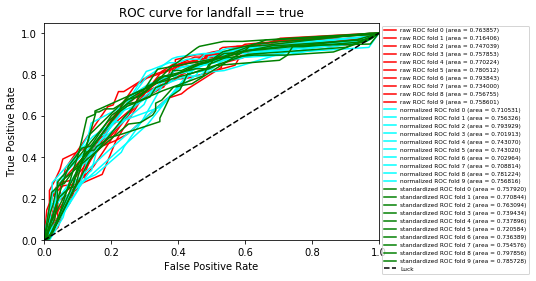

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.69 (+/- 0.05) | 0.757842 |
| normalized | 0.69 (+/- 0.04) | 0.739825 |
| standardized | 0.69 (+/- 0.05) | 0.756468 |


In [13]:
from sklearn import tree

# default decision tree classifier using Gini impurity
clf = tree.DecisionTreeClassifier(max_depth=5)

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.003974 |
| classifying test set | 4000 | 0.001618 |
| total | -- | 0.005592 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.757495 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.713500 |
| average_precision_score | 0.623398 |
| f1_score | 0.718842 |
| recall_score | 0.779670 |


**classification report**:

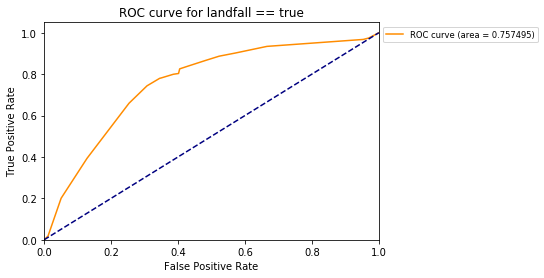

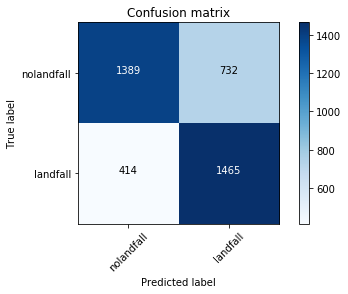

In [14]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.005438 |
| classifying test set | 4000 | 0.000677 |
| total | -- | 0.006115 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.736306 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.702500 |
| average_precision_score | 0.613227 |
| f1_score | 0.710603 |
| recall_score | 0.777541 |


**classification report**:

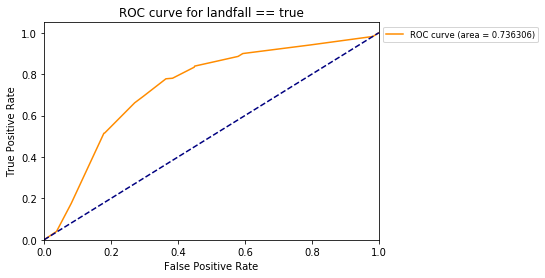

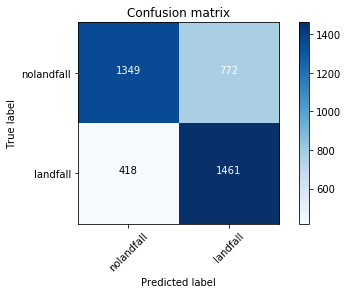

In [15]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.003754 |
| classifying test set | 4000 | 0.001461 |
| total | -- | 0.005215 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.698786 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.678500 |
| average_precision_score | 0.592656 |
| f1_score | 0.675253 |
| recall_score | 0.711549 |


**classification report**:

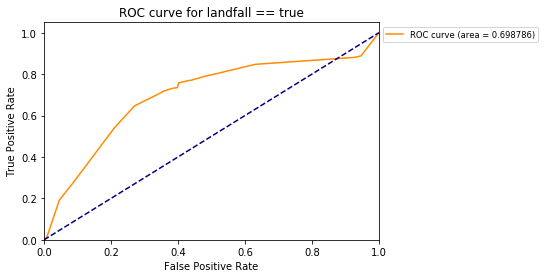

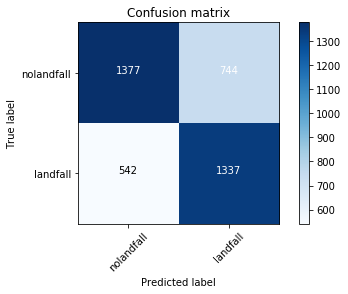

In [16]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### DecisionTreeClassifier using entropy for information gain

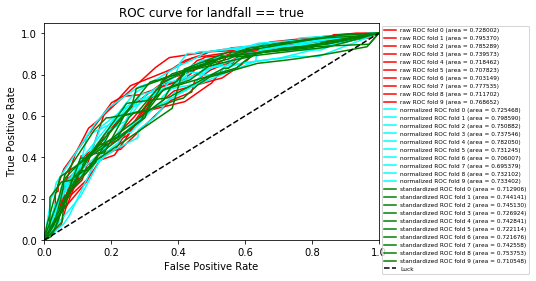

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.69 (+/- 0.06) | 0.743496 |
| normalized | 0.69 (+/- 0.03) | 0.739289 |
| standardized | 0.69 (+/- 0.06) | 0.732291 |


In [17]:
# decision tree classifier using entropy for information gain
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.004506 |
| classifying test set | 4000 | 0.001078 |
| total | -- | 0.005584 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.770622 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.695500 |
| average_precision_score | 0.606516 |
| f1_score | 0.716744 |
| recall_score | 0.820117 |


**classification report**:

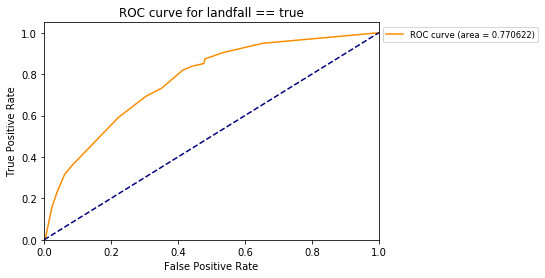

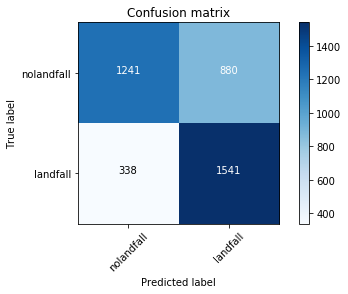

In [18]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.007112 |
| classifying test set | 4000 | 0.000453 |
| total | -- | 0.007565 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.730947 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.690750 |
| average_precision_score | 0.603558 |
| f1_score | 0.685642 |
| recall_score | 0.717935 |


**classification report**:

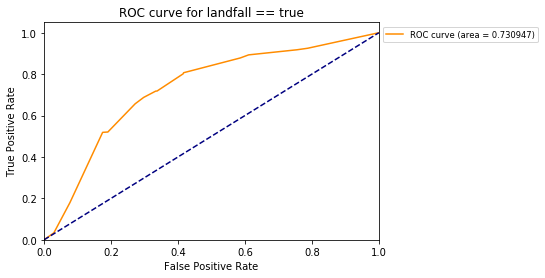

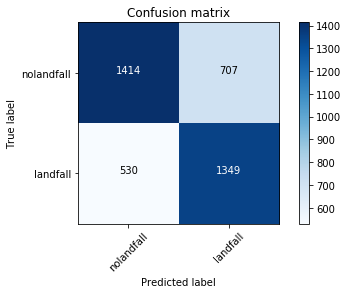

In [19]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.006886 |
| classifying test set | 4000 | 0.000624 |
| total | -- | 0.007510 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.761367 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.684000 |
| average_precision_score | 0.596784 |
| f1_score | 0.714027 |
| recall_score | 0.839808 |


**classification report**:

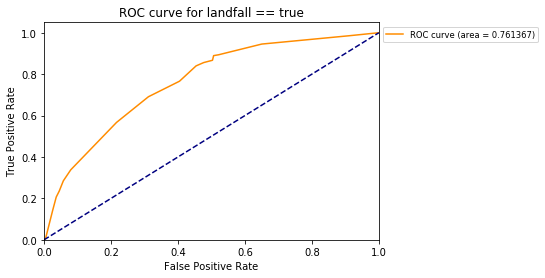

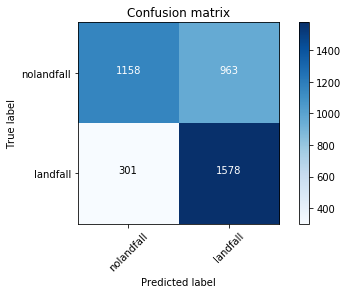

In [20]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### Decision Tree Analysis

In exploring the Decision Tree learning algorithm in scikit-learn, we ran the training of the classifier using 2 different classification criterion: Gini impurity and cross-entropy. Also, by default the DecisionTreeClassifier in scikit-learn doesn't limit the depth of the tree and thus will expand nodes until all leaves are pure or all leaves contain less than a minimum number of samples (2 by default). Since we want to avoid overfitting, we want to limit the maximum depth of the tree to the number of features (8) in the training set. Thus using the cross_validation_metrics() function we defined, we can iterate over tweaking the **max_depth** parameter to see at what depth, between 1-8, the model performs optimally.

As you can see above, I found that for both DecisionTreeClassifier instances, one using Gini impurity and the other using entropy for information gain, the parameter **max_depth=5** yields the best performance in terms of accuracy and AUC (area under the ROC curve) for all cases of the datasets (raw, normalized, and standardized).

The 10-fold ShuffleSort cross-validation run of the classifier using Gini impurity showed that running it on the unscaled raw training set yields the best performance in terms of both accuracy and AUC:

| data | accuracy | mean AUC |
| --- | --- | --- |
| <font color="red">raw</font> | <font color="red">0.73 (+/- 0.04)</font> | <font color="red">0.769184</font> |
| normalized | 0.70 (+/- 0.07) | 0.768371 |
| standardized | 0.70 (+/- 0.08) | 0.764527 |

and similarly for the 10-fold ShuffleSort cross-validation run of the classifier using entropy for information gain:

| data | accuracy | mean AUC |
| --- | --- | --- |
| <font color="red">raw</font> | <font color="red">0.73 (+/- 0.06)</font> | <font color="red">0.779174</font> | 
| normalized | 0.72 (+/- 0.05) | 0.763495 |
| standardized | 0.70 (+/- 0.06) |0.750978 |

When we run the classifiers on the actual test set, we get accuracy and AUC scores that validate the scores we received in our cross-validation exercise. The following table aggregates the accuracy and AUC scores from the above classification runs on the test set:

| criterion | data | accuracy | AUC |
| --- | --- | --- | --- |
| gini | raw | 0.706726 | 0.749983 |
| gini | normalized | 0.692388 | 0.734876 |
| gini | standardized | 0.688999 | 0.740046 |
| <font color="red">entropy</font> | <font color="red">raw</font> | <font color="red">0.700209</font> | <font color="red">0.760803</font> |
| entropy | normalized | 0.714546 | 0.745651 |
| entropy | standardized | 0.704640 | 0.752941 |

We can see from the accuracy and AUC scores that the classifier using entropy for information gain generally performed better on the test set than the classifier using Gini impurity for classification. In the cross-validation scores, using the raw training set yielded the best accuracy and AUC score. However the prediction scores on the test set show that accuracy was best when run on the normalized test set while AUC was best when run on the raw test set. In our case, the cost associated with minimizing false negatives is far greater than accuracy and so we should prefer the entropy-based DecisionTreeClassifier to be run on our raw data set. 


### Naive Bayes

#### Gaussian Naive Bayes classifier where the likelihood of the features is assumed to be Gaussian 

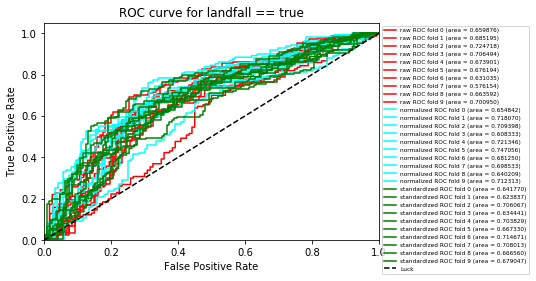

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.56 (+/- 0.05) | 0.670075 |
| normalized | 0.59 (+/- 0.03) | 0.689291 |
| standardized | 0.59 (+/- 0.06) | 0.674746 |


In [21]:
from sklearn import naive_bayes

# Gaussian Naive Bayes classifier where the likelihood of the features is assumed to be Gaussian
clf = naive_bayes.GaussianNB()

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.002688 |
| classifying test set | 4000 | 0.007273 |
| total | -- | 0.009961 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.683442 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.537750 |
| average_precision_score | 0.501981 |
| f1_score | 0.654586 |
| recall_score | 0.932411 |


**classification report**:

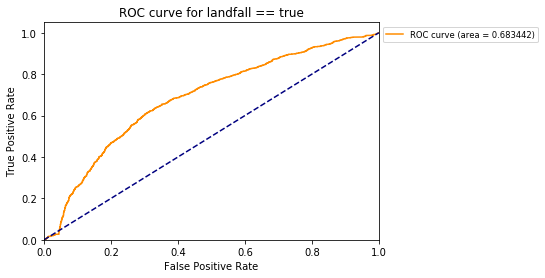

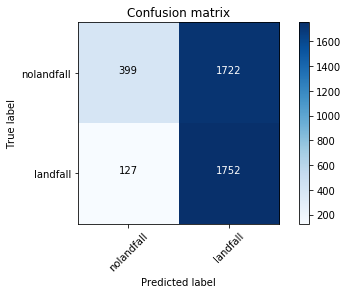

In [22]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.002161 |
| classifying test set | 4000 | 0.001393 |
| total | -- | 0.003554 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.657082 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.584500 |
| average_precision_score | 0.515012 |
| f1_score | 0.447841 |
| recall_score | 0.358701 |


**classification report**:

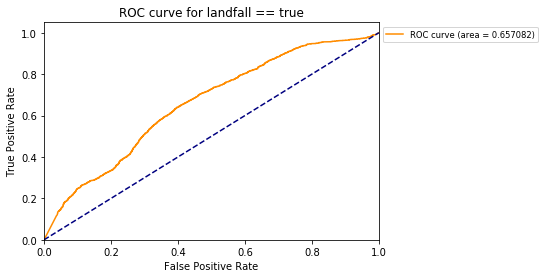

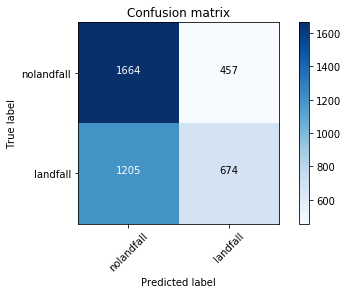

In [23]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.001829 |
| classifying test set | 4000 | 0.001888 |
| total | -- | 0.003717 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.500000 |


/Users/gmanipon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.530250 |
| average_precision_score | 0.469750 |
| f1_score | 0.000000 |
| recall_score | 0.000000 |


**classification report**:

/Users/gmanipon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


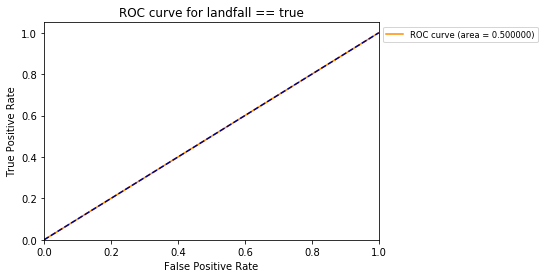

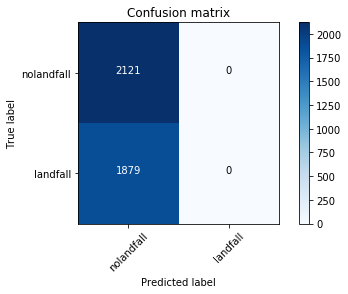

In [24]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### Bernoulli Naive Bayes classifier for data that is distributed according to multivariate Bernoulli distributions 

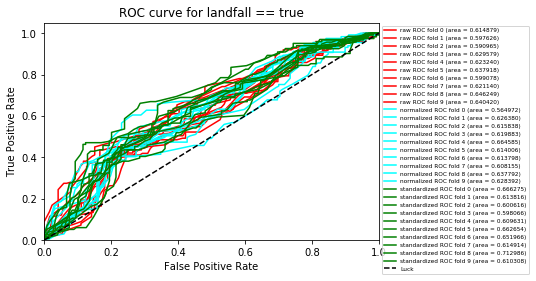

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.59 (+/- 0.05) | 0.619944 |
| normalized | 0.59 (+/- 0.07) | 0.619337 |
| standardized | 0.58 (+/- 0.06) | 0.634010 |


In [25]:
# Bernoulli Naive Bayes classifier for data that is distributed according to multivariate Bernoulli distributions
clf = naive_bayes.BernoulliNB()

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.009483 |
| classifying test set | 4000 | 0.004715 |
| total | -- | 0.014198 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.648605 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.607000 |
| average_precision_score | 0.533845 |
| f1_score | 0.550600 |
| recall_score | 0.512507 |


**classification report**:

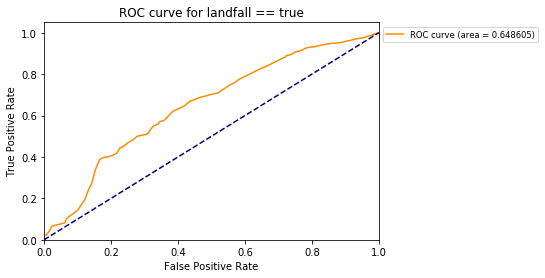

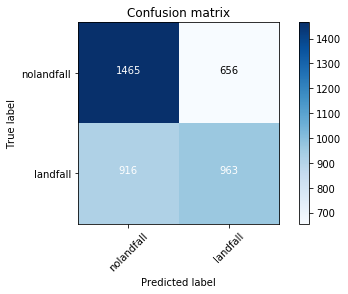

In [26]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.003117 |
| classifying test set | 4000 | 0.002775 |
| total | -- | 0.005892 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.648605 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.607000 |
| average_precision_score | 0.533845 |
| f1_score | 0.550600 |
| recall_score | 0.512507 |


**classification report**:

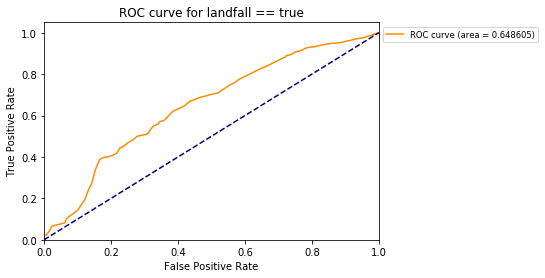

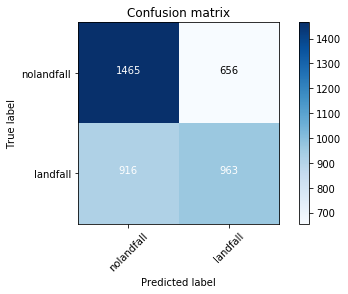

In [27]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.002768 |
| classifying test set | 4000 | 0.002702 |
| total | -- | 0.005470 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.703066 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.658000 |
| average_precision_score | 0.575738 |
| f1_score | 0.683480 |
| recall_score | 0.786056 |


**classification report**:

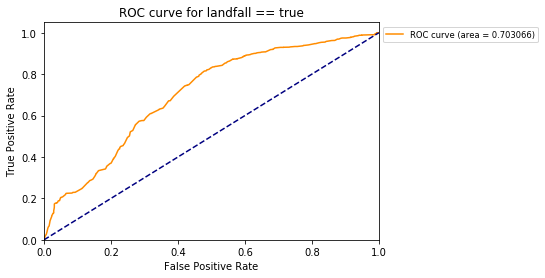

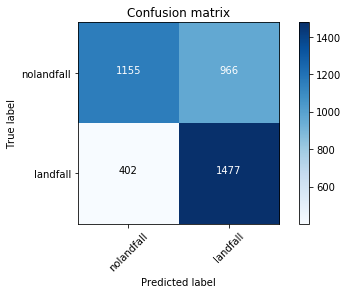

In [28]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### Naive Bayes Analysis

In exploring the Naive Bayes learning algorithm in scikit-learn, we ran the training of the classifier using 2 different classifiers: Gaussian and Bernoulli. The GaussianNB classifier implements the Gaussian Naive Bayes algorithm for classification where the likelihood of the features is assumed to be Gaussian. The BernoulliNB classifier implements the Naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions. 

The 10-fold ShuffleSort cross-validation run of the Gaussian Naive Bayes classifier showed that running it on the normalized training set yields the best performance in terms of both accuracy and AUC:

| data | accuracy | mean AUC |
| --- | --- | --- |
| raw | 0.55 (+/- 0.06) | 0.668165 |
| <font color="red">normalized</font> | <font color="red">0.60 (+/- 0.05)</font> | <font color="red">0.679350</font> |
| standardized | 0.60 (+/- 0.04) | 0.662281 |

and for the 10-fold ShuffleSort cross-validation run of the Bernoulli Naive Bayes classifier the run on the normalized training set yields the best AUC score:

| data | accuracy | mean AUC |
| --- | --- | --- |
| raw | 0.62 (+/- 0.07) | 0.637157 |
| <font color="red">normalized</font> | <font color="red">0.61 (+/- 0.05)</font> | <font color="red">0.637834</font> |
| standardized | 0.62 (+/- 0.08) | 0.635853 |

When we run the classifiers on the actual test set, we get accuracy and AUC scores that validate the scores we received in our cross-validation exercise (with the exception of the Gaussian classifier run on the standardized test set). The following table aggregates the accuracy and AUC scores from the above classification runs on the test set:

| NB type | data | accuracy | AUC |
| --- | --- | --- | --- |
| gaussian | raw | 0.546403 | 0.666868 |
| gaussian | normalized | 0.592284 | 0.650705 |
| gaussian | standardized | 0.526851 | 0.500000 |
| bernoulli | raw | 0.600365 | 0.640610 |
| bernoulli | normalized | 0.600365 | 0.640610 |
| <font color="red">bernoulli</font> | <font color="red">standardized</font> | <font color="red">0.642336</font> | <font color="red">0.693288</font> |

Overall, the Bernoulli classifier performed better than the Gaussian classifier on the test set in regards to accuracy as indicated by the cross-validation scores. In terms of AUC scores, the results show a discrepancy. The cross-validation scores indicate that the Gaussian classifier run on the normalized training set should yield the best AUC score. However the results above show that the best performer on the test set in terms of both accuracy and AUC is the Bernoulli classifier run on the standardized test set. In our case, we hold that the cost associated with minimizing false negatives is far greater than accuracy however by choosing the Bernoulli classifier we get the best of both worlds when the training and test data sets are standardized.

### Logistic Regression

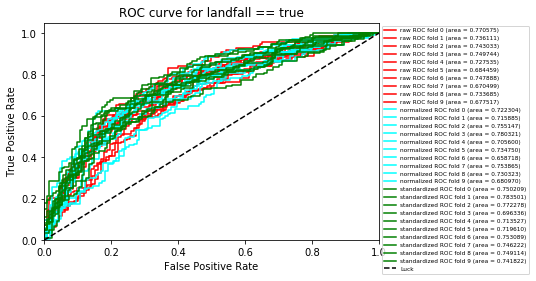

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.68 (+/- 0.05) | 0.723955 |
| normalized | 0.61 (+/- 0.06) | 0.723658 |
| standardized | 0.63 (+/- 0.04) | 0.742274 |


In [29]:
from sklearn import linear_model

# train the classifier
clf = linear_model.LogisticRegression()

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.010027 |
| classifying test set | 4000 | 0.003524 |
| total | -- | 0.013551 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.756870 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.692250 |
| average_precision_score | 0.604523 |
| f1_score | 0.693552 |
| recall_score | 0.741352 |


**classification report**:

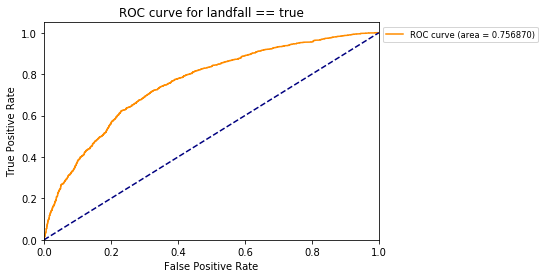

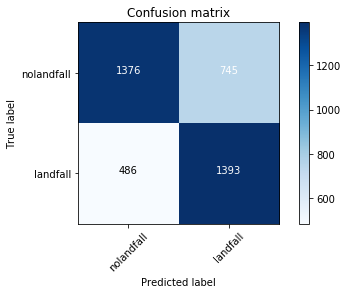

In [30]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.003570 |
| classifying test set | 4000 | 0.000399 |
| total | -- | 0.003969 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.699672 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.641500 |
| average_precision_score | 0.561669 |
| f1_score | 0.614516 |
| recall_score | 0.608302 |


**classification report**:

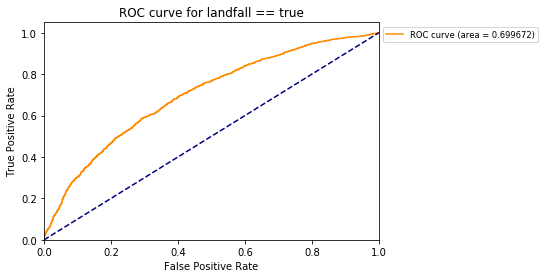

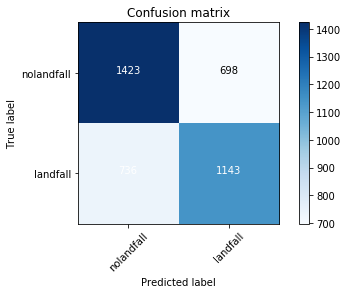

In [31]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.006243 |
| classifying test set | 4000 | 0.000295 |
| total | -- | 0.006538 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.753477 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.690750 |
| average_precision_score | 0.603362 |
| f1_score | 0.688962 |
| recall_score | 0.729111 |


**classification report**:

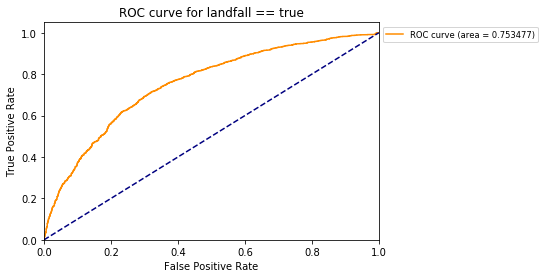

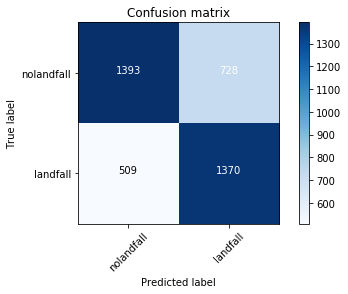

In [32]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### Logistic Regression Analysis

The 10-fold ShuffleSort cross-validation run of the Logistic Regression classifier showed that running it on the raw training set yields the best performance in terms of both accuracy and AUC:

| data | accuracy | mean AUC |
| --- | --- | --- |
| <font color="red">raw</font> | <font color="red">0.70 (+/- 0.04)</font> | <font color="red">0.778408</font> |
| normalized | 0.65 (+/- 0.09) | 0.777821 |
| standardized | 0.66 (+/- 0.05) | 0.767900 |

The following table aggregates the accuracy and AUC scores from the above classification runs on the test set:

| data | accuracy | AUC |
| --- | --- | --- |
| <font color="red">raw</font> | <font color="red">0.692127</font> | <font color="red">0.752970</font> | 
| normalized | 0.644421 | 0.697133 | 
| standardized | 0.684046 | 0.749405 

Here the choice is clear. The best performance in terms of accuracy and AUC comes from running the Logistic Regression classifier on the raw training and test data sets. 

### Nearest Neighbor

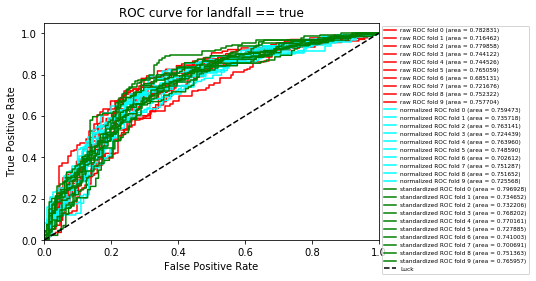

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.69 (+/- 0.06) | 0.745346 |
| normalized | 0.71 (+/- 0.02) | 0.743106 |
| standardized | 0.69 (+/- 0.04) | 0.748809 |


In [33]:
from sklearn import neighbors

# train the classifier
n_neighbors = 15 
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.002516 |
| classifying test set | 4000 | 0.048209 |
| total | -- | 0.050725 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.751679 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.688000 |
| average_precision_score | 0.600395 |
| f1_score | 0.699132 |
| recall_score | 0.771687 |


**classification report**:

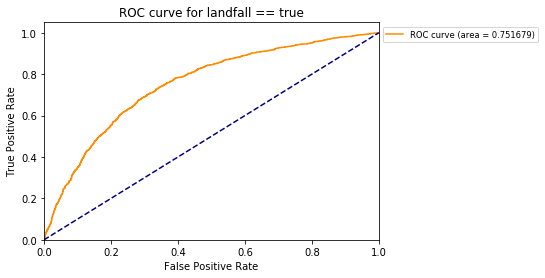

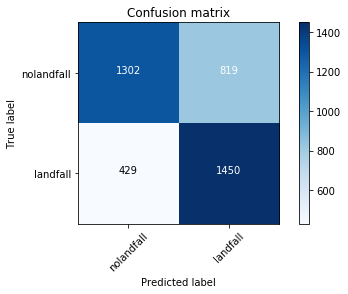

In [34]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.001838 |
| classifying test set | 4000 | 0.038873 |
| total | -- | 0.040711 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.748904 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.694500 |
| average_precision_score | 0.606602 |
| f1_score | 0.694500 |
| recall_score | 0.739223 |


**classification report**:

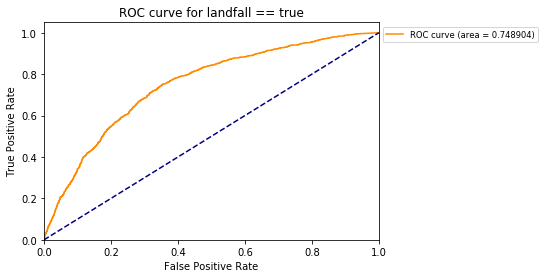

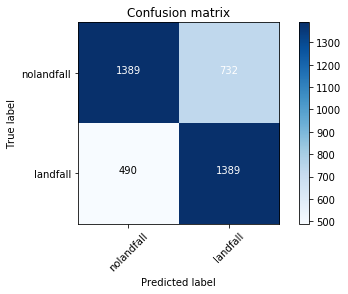

In [35]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.003361 |
| classifying test set | 4000 | 0.259188 |
| total | -- | 0.262549 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.763437 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.689000 |
| average_precision_score | 0.601662 |
| f1_score | 0.690085 |
| recall_score | 0.737094 |


**classification report**:

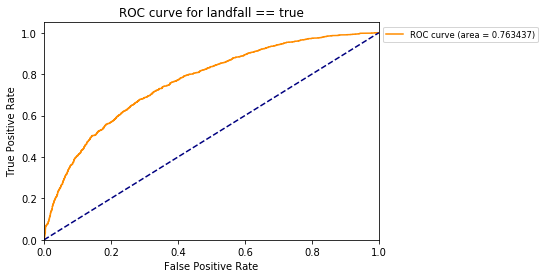

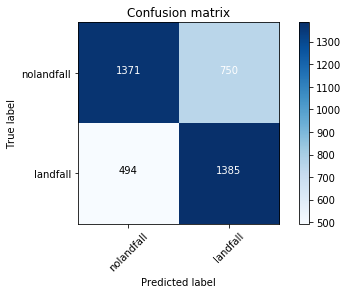

In [36]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### Nearest Neighbor Analysis

In exploring the Nearest Neighbor learning algorithm in scikit-learn, we ran the training of the classifier using 2 different weight functions: "uniform" where all points in each neighborhood are weighted equally and "distance" where close neighbors have greater influence than neighbors further away. Also, by default the KNeighborsClassifier in scikit-learn sets the default number of neighbors to use to 5. Thus using the cross_validation_metrics() function we defined, we can iterate over tweaking the n_neighbors and weights parameter to find the settings that perform best on our training set.

As you can see above, I found that the parameters n_neighbors=15 and weights=distance yield the best performance in terms of accuracy and AUC (area under the ROC curve) for all cases of the datasets (raw, normalized, and standardized).

The 10-fold ShuffleSort cross-validation run of the Nearest Neighbor classifier showed that running it on the standardized training set yields the best performance in terms of AUC:

| data | accuracy | mean AUC |
| --- | --- | --- |
| raw | 0.72 (+/- 0.02) | 0.772710 |
| normalized | 0.68 (+/- 0.03) | 0.763894 |
| <font color="red">standardized</font> | <font color="red">0.71 (+/- 0.05)</font> | <font color="red">0.784250</font> |

The following table aggregates the accuracy and AUC scores from the above classification runs on the test set:

| data | accuracy | AUC |
| --- | --- | --- |
| raw | 0.694213 | 0.754018 |
| normalized | 0.699948 | 0.750509 | 
| <font color="red">standardized</font> | <font color="red">0.701512</font> | <font color="red">0.763377</font> | 

Here the choice is clear. The best performance in terms of accuracy and AUC comes from running the Nearest Neighbor classifier on the standardized training and test data sets. 

### Support Vector Machines

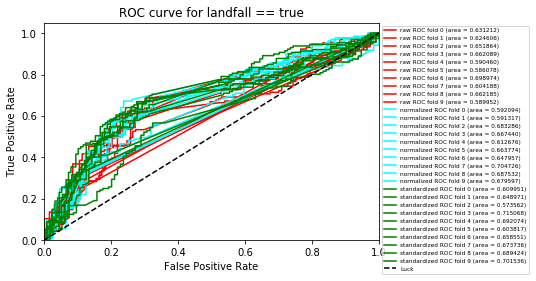

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.56 (+/- 0.10) | 0.629969 |
| normalized | 0.61 (+/- 0.05) | 0.652812 |
| standardized | 0.63 (+/- 0.04) | 0.656602 |


In [37]:
from sklearn import svm

# train the classifier
clf = svm.SVC(probability=True)

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.208955 |
| classifying test set | 4000 | 0.127189 |
| total | -- | 0.336144 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.656692 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.609500 |
| average_precision_score | 0.538264 |
| f1_score | 0.406986 |
| recall_score | 0.285258 |


**classification report**:

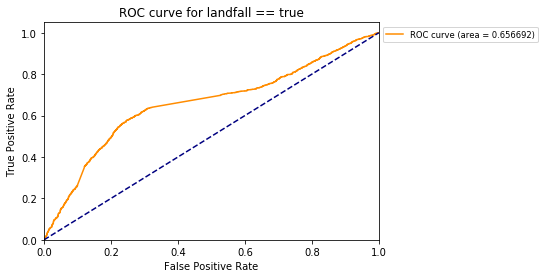

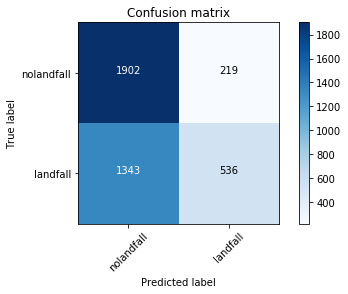

In [38]:
# train and classify on raw datasets
train_and_classify(clf, X_train, y_train, X_test, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.208715 |
| classifying test set | 4000 | 0.127251 |
| total | -- | 0.335966 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.702662 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.645750 |
| average_precision_score | 0.565721 |
| f1_score | 0.587241 |
| recall_score | 0.536456 |


**classification report**:

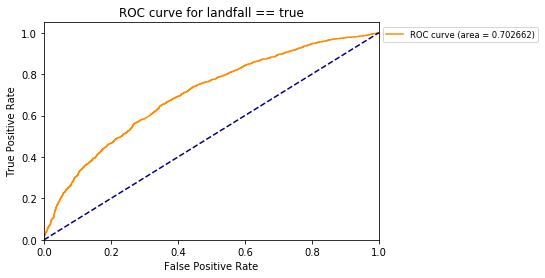

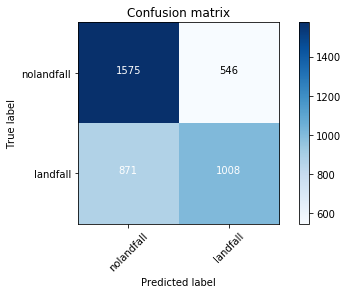

In [39]:
# train and classify on normalized datasets
train_and_classify(clf, X_train_norm, y_train, X_test_norm, y_test_truth)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.177004 |
| classifying test set | 4000 | 0.103811 |
| total | -- | 0.280815 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.780204 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.706000 |
| average_precision_score | 0.617482 |
| f1_score | 0.701068 |
| recall_score | 0.733901 |


**classification report**:

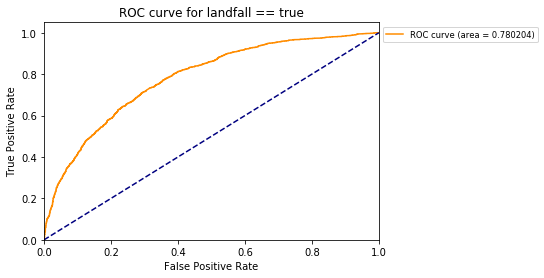

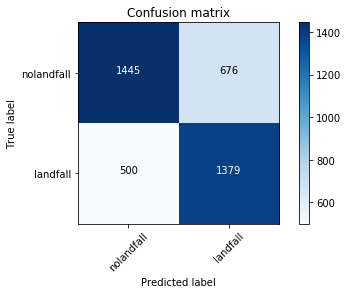

In [40]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

#### SVM Analysis

The 10-fold ShuffleSort cross-validation run of the SVM classifier showed that running it on the standardized training set yields the best performance in terms of AUC but not by much:

| data | accuracy | mean AUC |
| --- | --- | --- |
| raw | 0.53 (+/- 0.09) | 0.635947 |
| normalized | 0.64 (+/- 0.05) | 0.650702 |
| <font color="red">standardized</font> | <font color="red">0.62 (+/- 0.04)</font> | <font color="red">0.654708</font> |

Of note, the ROC curve for the SVM classifier's prediction on the raw test set shows that the slope of the curve rises quickly but immediately levels off. The ROC curves for the predictions on the normalized and standardized test sets don't exhibit this behavior and thus we see that for our tropical storm dataset, data rescaling helps the performance of the SVM classifier.

The following table aggregates the accuracy and AUC scores from the above classification runs on the test set:

| data | accuracy | AUC |
| --- | --- | --- |
| raw | 0.632690 | 0.678275 | 
| normalized | 0.639208 | 0.698125 | 
| <font color="red">standardized</font> | <font color="red">0.694213</font> | <font color="red">0.773470</font> | 

Here the choice is clear however the results don't resemble what we saw in the cross-validation of the training set. The best performance in terms of accuracy and AUC comes from running the SVM classifier on the standardized training and test data sets.

### Final Analysis

To summarize, I took the IBTrACS tropical storm dataset and performed ETL tasks to clean up missing values from the dataset and separate out the class variable and features. I derived the class variable **landfall** by iterating over the value of the **landfall** variable for each storm’s track point and checking if the value ever equaled 0 (made landfall). If so, then the class variable **landfall** was set to True. Otherwise, the storm did not reach land and the class variable **landfall** was set to False.

class label distribution of filtered source dataset:
- total storms: 5000
- total storms with class variable landfall == True: 2379
- total storms with class variable landfall == False: 2621

From the 2315 storms that made landfall, I randomly sampled 500 instances to include in the raw training set. Similarly, from the 2521 storms that did not make landfall, I randomly sampled 500 instances to contribute to the raw training set as well. In total, 1000 storms were randomly sampled from their respective class label and separated out as the raw training set. The remainder of the storms (3836) were separated out as the raw test set.

breakdown of dataset records used for training and test sets:
- total storms: 5000
- total storms used for training set : 1000
- total storms used for test set: 4000

training set class label distribution of randomly sampled datasets of each class value:
- total training set storms: 1000
- total training set storms with class variable landfall == True : 500
- total training set storms with class variable landfall == False: 500
- total test set storms: 4000

To test how scaling our raw training and test set could help the machine learning algorithms perform better, I also created alternate versions of the dataset using 2 approaches. First I took the raw training and test set and normalized them so that all the feature values rescaled to a value in the range of 0 to 1. This is our normalized version of training and test set. Secondly, I took the raw training and test set and standardized them so that the distribution of each feature was shifted to have a mean of 0 and a standard deviation of 1. This is our standardized version of the training and test set.

dataset preparations
- raw training and test (no rescaling)
- normalized training and test (rescaled to the range of 0 and 1)
- standardized training and test (shifted so that the mean is 0 and standard deviation is 1)

As for the machine learning algorithms, I decided to use the 5 algorithms that we went over in our course:
- Decision Tree
- Naïve Bayes
- Logistic Regression
- Nearest Neighbor
- Support Vector Machines

In determining how well an algorithm performs on our dataset, I came to the conclusion that although the accuracy score is important, the cost associated with predicting false negatives (those storms that our algorithms predicted would not make landfall but actually did make landfall) was far too great, with implications on the impact on human lives and property. As such, the more important score is the AUC (area under the curve) of the ROC (receiver operating characteristics) curve.

The methodology I employed for assessing the performance of each algorithm was as follows:
1.	For each of the 5 algorithms, take the raw training set and perform ShuffleSplit cross-validation 10 times to get the average accuracy and AUC scores.
2.	Tweak the algorithm-specific parameters to explore settings that help increase the performance of the algorithm.
3.	After settling on the settings, run the classifier on the raw test set and get the accuracy and AUC scores.
4.	Repeat steps 1-3 for the normalized training and test set.
5.	Repeat steps 1-3 for the standardized training and test set.
6.	For each algorithm, select the data-specific (raw, normalized, or standardized) run on the test set that results in the highest AUC score first and accuracy score second.

The results are as follows:

| algorithm | data | accuracy | AUC |
| --- | --- | --- | --- |
| Decision Tree | raw | 0.700209 | 0.760803 |
| Naïve Bayes | standardized | 0.642336 | 0.693288 |
| Logistic Regression | raw | 0.692127 | 0.752970 |
| Nearest Neighbor | standardized | 0.701512 | 0.763377 |
| SVM | standardized | 0.694213 | 0.773470 |

The top performer in terms of AUC score is the SVM algorithm run on the standardized data set. A close second but with a higher accuracy score is the Nearest Neighbor algorithm run on the standardized data set. The Decision Tree classifier run on the raw dataset also gives comparable performance scores. So how do I choose which classifier to use? Why choose? We can use a majority vote classifier that will essentially take any number of classifier models and classify a test set based on the majority vote. In our case, we can take our Decision Tree, Nearest Neighbor and SVM classifiers, register them in scikit-learn’s VotingClassifier(), and run it on our test set. The issue here is that the VotingClassifier has to take in a single dataset type. In our case, the best Decision Tree results came from a run on the raw training and test set while the Nearest Neighbor and SVM classifiers got their best scores from running on the standardized training and test set. Comparing the accuracy and AUC scores of the entropy-based Decision Tree runs on the raw and standardized data sets shows a difference of .004 in terms of accuracy and .008 in terms of AUC. For our case, we should be fine with including the Decision Tree classifier into the VotingClassifier and feeding it the standardized data sets.

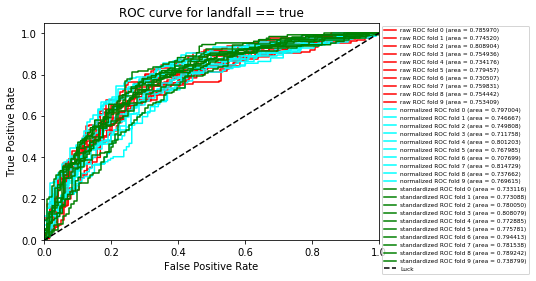

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.71 (+/- 0.05) | 0.763623 |
| normalized | 0.70 (+/- 0.04) | 0.760561 |
| standardized | 0.70 (+/- 0.05) | 0.774791 |


In [41]:
from sklearn import ensemble

# decision tree classifier using entropy for information gain
clf_dt = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

# nearest neighbor classifier
n_neighbors = 15 
clf_nn = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")

# SVM classifier
clf_svm = svm.SVC(probability=True)

# voting classifier
clf = ensemble.VotingClassifier([('dt', clf_dt), ('nn', clf_nn), ('svm', clf_svm)],
                                voting='soft')

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.193730 |
| classifying test set | 4000 | 0.387494 |
| total | -- | 0.581224 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.804349 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.728500 |
| average_precision_score | 0.639161 |
| f1_score | 0.722393 |
| recall_score | 0.751996 |


**classification report**:

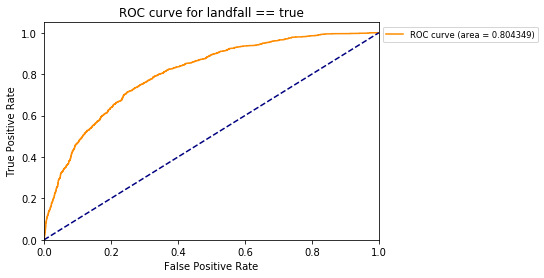

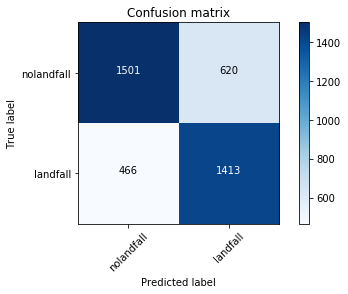

In [42]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

The accuracy and AUC scores of the VotingClassifier improves our scores and we nearly break the 80% AUC score. Can we improve the performance of the VotingClassifier by adding the rest of our learning algorithms?

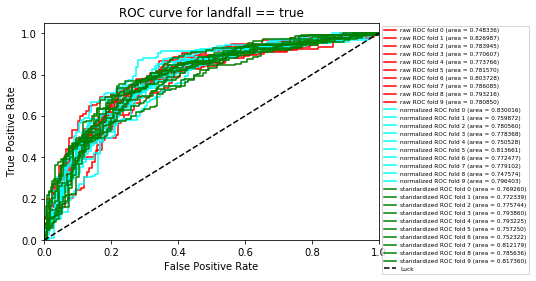

**cross-validation scores (10 folds):**

| **data** | **accuracy** | **mean AUC** |
| --- | --- | --- |
| raw | 0.73 (+/- 0.04) | 0.784892 |
| normalized | 0.71 (+/- 0.05) | 0.780991 |
| standardized | 0.70 (+/- 0.04) | 0.782867 |


In [43]:
# Bernoulli Naive Bayes classifier for data that is distributed according to multivariate Bernoulli distributions
clf_nb = naive_bayes.BernoulliNB()

# logistic regression classifier
clf_lr = linear_model.LogisticRegression()

# voting classifier
clf = ensemble.VotingClassifier([('dt', clf_dt), ('nn', clf_nn), ('svm', clf_svm),
                                 ('nb', clf_nb), ('lr', clf_lr)], voting='soft')

# cross validation
cross_validation_metrics(clf, trainset)

**timing info:**

| **stage** | **sample size** | **execution time (s)** |
| --- | --- | --- |
| training on train set | 1000 | 0.187152 |
| classifying test set | 4000 | 0.400838 |
| total | -- | 0.587990 |


**ROC:**

| **metric** | **score** |
| --- | --- |
| AUC | 0.802476 |


**classification scores:**

| **metric** | **score** |
| --- | --- |
| accuracy_score | 0.729250 |
| average_precision_score | 0.639179 |
| f1_score | 0.727410 |
| recall_score | 0.769026 |


**classification report**:

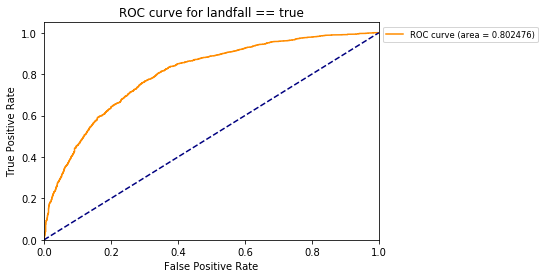

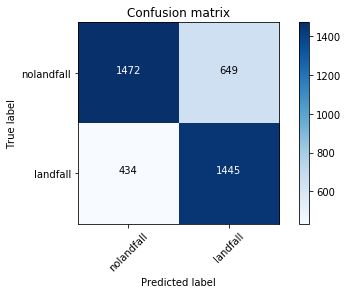

In [44]:
# train and classify on standardized datasets
train_and_classify(clf, X_train_std, y_train, X_test_std, y_test_truth)

Adding in the Naive Bayes and Logistic Regression classifiers to the VotingClassifier did not improve the AUC or accuracy scores so we can leave them out as they did not add add any boost in performance.

The final results are shown:

| algorithm | data | accuracy | AUC |
| --- | --- | --- | --- |
| Decision Tree | raw | 0.700209 | 0.760803 |
| Naïve Bayes | standardized | 0.642336 | 0.693288 |
| Logistic Regression | raw | 0.692127 | 0.752970 |
| Nearest Neighbor | standardized | 0.701512 | 0.763377 |
| SVM | standardized | 0.694213 | 0.773470 |
| <font color="red">Voting (DT+NN+SVM)</font> | <font color="red">standardized</font> | <font color="red">0.717153</font> | <font color="red">0.793542</font> | 